<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/localPeriodicPattern/basic/LPPMBreadth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Local Periodic patterns in Temporal Databases using LPPMBreadth

 In the tutorial, we describe the basic approach to find Local Periodic patterns in a Temporal database using the LPPMBreadth algorithm on a dataset at user Specified minimum support threshold value.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 18.3 MB/s eta 0:00:00
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=b67d55e160346a6a822f5d6cf932bda8d8cd1621f7d68e4127965386a0d86c33
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4753 sha256=5c01bfdbe5b9dc2fce924b07d3dab2c49608cba5706e26fd1d1cf743776fbeaf
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-11-28 17:45:01--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M   990KB/s    in 5.4s    

2023-11-28 17:45:08 (830 KB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Finding Local Periodic patterns using LPPMBreadth

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.TemporalDatabase as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.TemporalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

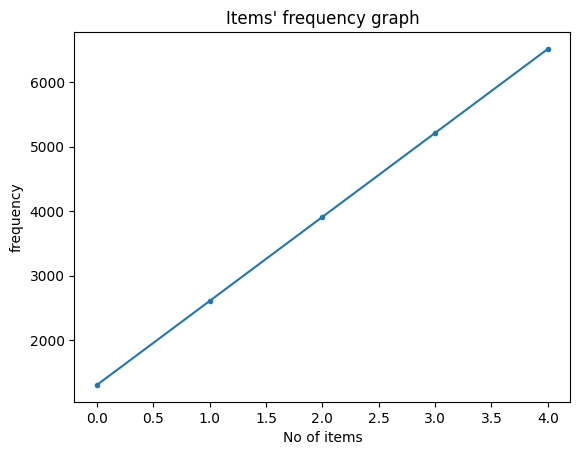

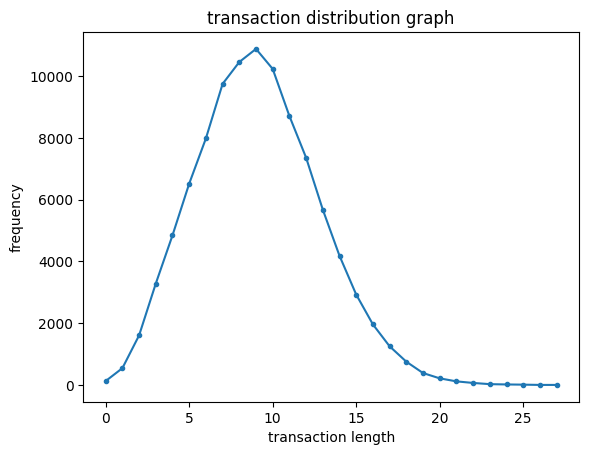

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 500 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
maximumPeriodicity = 50 #Users can also specify this constraint between 0 to 1.
maximumSpilOverPeriod = 50 #Users can also specify this constraint between 0 to 1.
minSup = 500 #Users can also specify this constraint between 0 to 1.

### Step 4: Mining Local Periodic patterns using LPPMBreadth

In [7]:
from PAMI.localPeriodicPattern.basic import LPPMBreadth as alg #import the algorithm

obj = alg.LPPMBreadth(iFile=inputFile, maxPer=maximumPeriodicity, maxSoPer=maximumSpilOverPeriod, minDur=minSup, sep='\t') #initialize
obj.startMine()            #start the mining process

### Step 5: Storing the generated patterns

#### Step 5.1: Storing the generated patterns in a file

In [8]:
obj.save('localPeriodicFrequentPatternsAtMinSupCount500.txt')

#### Step 5.2. Storing the generated patterns in a data frame

In [9]:
frequentPatternsDF= obj.getPatternsAsDataFrame()

### Step 6: Getting the statistics

#### Step 6.1: Total number of discovered patterns

In [10]:
print('Total No of patterns: ' + str(len(frequentPatternsDF)))

Total No of patterns: 342


#### Step 6.2: Runtime consumed by the mining algorithm

In [11]:
print('Runtime: ' + str(obj.getRuntime()))

Runtime: 305.9930531978607


#### Step 6.3: Total Memory consumed by the mining algorithm

In [12]:
print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Memory (RSS): 263135232
Memory (USS): 240336896
